In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import shutil
import random
PROJ_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(PROJ_DIR, "src"))

from pkg.utils.utils_python3 import *
DATA_PATH = os.path.join(PROJ_DIR, "data")
LAT_DATA_PATH = os.path.join(DATA_PATH, "latticized")
MODEL_PATH = os.path.join(PROJ_DIR, "model")
LAT_MODEL_PATH = os.path.join(MODEL_PATH,"latticized")
try_mkdir(MODEL_PATH)
try_mkdir(LAT_MODEL_PATH)
GRASP_FOLDER = "grasp"
ARM10_FOLDER = "arm_10"
ARM05_FOLDER = "arm_05"
FULLS_FOLDER = "full_scene"

In [5]:
ROBOT_TYPE_NAME="indy7"
ROBOT_DATA_ROOT = os.path.join(LAT_DATA_PATH, ROBOT_TYPE_NAME)
# ROBOT_DATA_ROOT = LAT_DATA_PATH
ARM_FOLDER = ARM10_FOLDER

In [6]:
print(sorted(os.listdir(ROBOT_DATA_ROOT)))

['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319']


In [13]:
DATASET_TRAIN = ['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753']
DATASET_TEST = ['20210215-184319']
GRASP_SHAPE = (20,20,20)
ARM_SHAPE = (20,20,20)
RH_MASK_SIZE = 512
RH_MASK_STEP = 64

data_pairs_train = []
for dataset in DATASET_TRAIN:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
        
data_pairs_test = []
for dataset in DATASET_TEST:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))

In [16]:
# def div_r(r):
#     return floor(sigmoid((r)/0.1-8)*8)

def div_r(r):
    return floor(sigmoid((r)/0.1-7)*8)

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-4.5)*8)

def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_class = div_r(r_ej)
    h_class = div_h(h_ej)
    r_mask = np.zeros(RH_MASK_SIZE)
    r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
    h_mask = np.zeros(RH_MASK_SIZE)
    h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
    rh_mask = np.concatenate([r_mask, h_mask])
    # r_ej_list.append(r_ej)
    # h_ej_list.append(h_ej)
    # reach_lb_list.append(reach_lb)
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
#     grasp_img = np.stack([grasp_tool_img, np.logical_or(grasp_obj_img, grasp_tar_img)], axis=-1)
#     grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label

## Train

In [18]:
from pkg.planning.filtering.lattice_model.lattice_model import *

# Create an instance of the model
model = ResNetModelTP()

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [19]:
ROBOT_MODEL_ROOT =  os.path.join(LAT_MODEL_PATH, ROBOT_TYPE_NAME)
current_time = get_now()
logpath = os.path.join(ROBOT_MODEL_ROOT, current_time)
try_mkdir(logpath)
train_log_dir = os.path.join(logpath, 'train')
test_log_dir = os.path.join(logpath, 'test')
model_log_dir = os.path.join(logpath, 'model_{}/')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
shutil.copy(os.path.join(PROJ_DIR,'src', 'pkg','planning','filtering','lattice_model','lattice_model.py' ), logpath)
print(f'Log path: {logpath}')

Log path: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434


In [20]:
EPOCHS_S = 0
EPOCHS_E = 10
BATCH_SIZE = 16
LOG_STEP = 100
N_train = len(data_pairs_train)
N_test = len(data_pairs_test)

for epoch in range(EPOCHS_S, EPOCHS_E):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    random.shuffle(data_pairs_train)
    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_train:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            train_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("train step - {}/{}        ".format(i_step, N_train), end = '\r')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            
    model.save(model_log_dir.format(epoch + 1))

    print("")
    print("=================================================================")
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    print("=================================================================")
    print("")

INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_1/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_1/assets



Epoch 1, Loss: 0.5046480298042297, Accuracy: 76.4124984741211, Test Loss: 1.3895224332809448, Test Accuracy: 48.538307189941406



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_2/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_2/assets



Epoch 2, Loss: 0.3994753956794739, Accuracy: 82.9749984741211, Test Loss: 0.6114117503166199, Test Accuracy: 76.51210021972656



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_3/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_3/assets



Epoch 3, Loss: 0.37406325340270996, Accuracy: 83.7750015258789, Test Loss: 0.42986416816711426, Test Accuracy: 84.07257843017578



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_4/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_4/assets



Epoch 4, Loss: 0.3506791293621063, Accuracy: 86.26249694824219, Test Loss: 0.3679078221321106, Test Accuracy: 86.18951416015625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_5/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_5/assets



Epoch 5, Loss: 0.3094528615474701, Accuracy: 87.4000015258789, Test Loss: 0.5185724496841431, Test Accuracy: 84.42539978027344



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_6/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_6/assets



Epoch 6, Loss: 0.3004138469696045, Accuracy: 87.375, Test Loss: 0.4570869505405426, Test Accuracy: 85.38306427001953



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_7/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_7/assets



Epoch 7, Loss: 0.26523733139038086, Accuracy: 89.38749694824219, Test Loss: 0.5693395733833313, Test Accuracy: 82.61088562011719



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_8/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_8/assets



Epoch 8, Loss: 0.2615572512149811, Accuracy: 89.1624984741211, Test Loss: 0.4887036383152008, Test Accuracy: 85.63507843017578



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_9/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_9/assets



Epoch 9, Loss: 0.23282386362552643, Accuracy: 91.26250457763672, Test Loss: 0.4933619797229767, Test Accuracy: 80.69556427001953



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_10/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210216-004434/model_10/assets



Epoch 10, Loss: 0.21579575538635254, Accuracy: 91.88749694824219, Test Loss: 1.2177809476852417, Test Accuracy: 80.2923355102539



In [9]:
'''
old 5000 data train results
test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_1/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_1/assets

=================================================================
Epoch 1, Loss: 0.45571762323379517, Accuracy: 78.92372131347656, Test Loss: 1.224581241607666, Test Accuracy: 59.32499694824219
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_2/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_2/assets

=================================================================
Epoch 2, Loss: 0.3815981447696686, Accuracy: 83.21685028076172, Test Loss: 0.4036230146884918, Test Accuracy: 84.8499984741211
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_3/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_3/assets

=================================================================
Epoch 3, Loss: 0.3139594495296478, Accuracy: 87.01078033447266, Test Loss: 0.3281334638595581, Test Accuracy: 86.79999542236328
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_4/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_4/assets

=================================================================
Epoch 4, Loss: 0.29795971512794495, Accuracy: 88.12899780273438, Test Loss: 0.37520378828048706, Test Accuracy: 86.5999984741211
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_5/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_5/assets

=================================================================
Epoch 5, Loss: 0.2689083218574524, Accuracy: 89.50679016113281, Test Loss: 0.6793899536132812, Test Accuracy: 81.0
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_6/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_6/assets

=================================================================
Epoch 6, Loss: 0.27168962359428406, Accuracy: 89.6865005493164, Test Loss: 0.3858621418476105, Test Accuracy: 84.5
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_7/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_7/assets

=================================================================
Epoch 7, Loss: 0.24648518860340118, Accuracy: 90.49520874023438, Test Loss: 0.6083331108093262, Test Accuracy: 80.22500610351562
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_8/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_8/assets

=================================================================
Epoch 8, Loss: 0.2221241146326065, Accuracy: 91.73323059082031, Test Loss: 0.6551346182823181, Test Accuracy: 80.5999984741211
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_9/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_9/assets

=================================================================
Epoch 9, Loss: 0.20895960927009583, Accuracy: 92.2723617553711, Test Loss: 0.4034314453601837, Test Accuracy: 85.2750015258789
=================================================================

test step - 2000/2004         
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as conv1_layer_call_fn, conv1_layer_call_and_return_conditional_losses, activation_layer_call_fn, activation_layer_call_and_return_conditional_losses, conv_block3d_layer_call_fn while saving (showing 5 of 1360). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_10/assets
INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-225732/model_10/assets

=================================================================
Epoch 10, Loss: 0.18841445446014404, Accuracy: 93.35063934326172, Test Loss: 0.5855700969696045, Test Accuracy: 86.75
=================================================================

'''

INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_1/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_1/assets



Epoch 1, Loss: 0.5884613990783691, Accuracy: 71.04367065429688, Test Loss: 1.3194913864135742, Test Accuracy: 55.57500076293945



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_2/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_2/assets



Epoch 2, Loss: 0.4965505003929138, Accuracy: 77.55409240722656, Test Loss: 0.5040345191955566, Test Accuracy: 78.8499984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_3/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_3/assets



Epoch 3, Loss: 0.4839232563972473, Accuracy: 77.87460327148438, Test Loss: 0.6587375998497009, Test Accuracy: 78.94999694824219



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_4/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_4/assets



Epoch 4, Loss: 0.47873321175575256, Accuracy: 78.85617065429688, Test Loss: 0.47496241331100464, Test Accuracy: 79.69999694824219



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_5/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_5/assets



Epoch 5, Loss: 0.4614768326282501, Accuracy: 80.11819458007812, Test Loss: 0.5037769079208374, Test Accuracy: 78.79999542236328



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_6/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_6/assets



Epoch 6, Loss: 0.44722482562065125, Accuracy: 80.43870544433594, Test Loss: 0.5139892101287842, Test Accuracy: 79.42500305175781



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_7/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_7/assets



Epoch 7, Loss: 0.4139785170555115, Accuracy: 82.09134674072266, Test Loss: 0.5067081451416016, Test Accuracy: 79.2249984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_8/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_8/assets



Epoch 8, Loss: 0.40840381383895874, Accuracy: 82.21153259277344, Test Loss: 0.49995046854019165, Test Accuracy: 78.7249984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_9/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_9/assets



Epoch 9, Loss: 0.38114795088768005, Accuracy: 83.46354675292969, Test Loss: 0.6703913807868958, Test Accuracy: 78.5250015258789



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_10/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210214-224446/model_10/assets



Epoch 10, Loss: 0.3600918650627136, Accuracy: 84.755615234375, Test Loss: 0.4767046272754669, Test Accuracy: 79.875



In [11]:
grasp_img_batch.shape

(16, 20, 20, 20, 2)

In [ ]:
grasp_img_batch

In [18]:
save_json("grasp_img.json", np.where(grasp_img))
save_json("arm_img.json", np.where(arm_img))

## Load & test

In [11]:
last_model = sorted(os.listdir(LAT_MODEL_PATH))[-1]

In [12]:
logpath = os.path.join(LAT_MODEL_PATH, last_model)
last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")])[-1]
# last_save = "model_5"
model_log_dir = os.path.join(logpath, last_save)

In [13]:
import tensorflow as tf
model = tf.keras.models.load_model(model_log_dir)

In [14]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
loss_object = tf.keras.losses.BinaryCrossentropy()
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [15]:
BATCH_SIZE = 16
LOG_STEP = 100
N_test = len(data_pairs_test)
# Reset the metrics at the start of the next epoch
test_loss.reset_states()
test_accuracy.reset_states()

i_step = 0
data_batch, label_batch = [], []
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

print("")
print("=================================================================")
print(
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
)
print("=================================================================")
print("")

test step - 2000/2004        
Test Loss: 0.6434980630874634, Test Accuracy: 79.5999984741211



In [16]:
BATCH_SIZE = 16
LOG_STEP = 100
N_test = len(data_pairs_test)
# Reset the metrics at the start of the next epoch
test_loss.reset_states()
test_accuracy.reset_states()

i_step = 0
data_batch, label_batch = [], []
for data_pair in data_pairs_test:
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    if not label[-1]:
        continue
    i_step += 1
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

print("")
print("=================================================================")
print(
    f'True Test Loss: {test_loss.result()}, '
    f'True Test Accuracy: {test_accuracy.result() * 100}'
)
print("=================================================================")
print("")

test step - 900/2004        
True Test Loss: 0.5281128287315369, True Test Accuracy: 84.48092651367188



In [17]:
BATCH_SIZE = 16
LOG_STEP = 100
N_test = len(data_pairs_test)
# Reset the metrics at the start of the next epoch
test_loss.reset_states()
test_accuracy.reset_states()

i_step = 0
data_batch, label_batch = [], []
for data_pair in data_pairs_test:
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    if label[-1]:
        continue
    i_step += 1
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

print("")
print("=================================================================")
print(
    f'False Test Loss: {test_loss.result()}, '
    f'False Test Accuracy: {test_accuracy.result() * 100}'
)
print("=================================================================")
print("")

test step - 1000/2004        
False Test Loss: 0.7470025420188904, False Test Accuracy: 75.24038696289062



## test on shared array

In [18]:
import SharedArray as sa
BATCH_SIZE = 1
SERVER_PERIOD = 1e-2
# Create an array in shared memory.
robot_type_p = sa.attach("shm://robot_type")
grasp_img_p = sa.attach("shm://grasp_img")
arm_img_p = sa.attach("shm://arm_img")
rh_mask_p = sa.attach("shm://rh_mask")
result_p = sa.attach("shm://result")
query_in = sa.attach("shm://query_in")
response_out = sa.attach("shm://response_out")
query_quit = sa.attach("shm://query_quit")

def query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch):
    grasp_img_p[:] = grasp_img_batch[:]
    arm_img_p[:] = arm_img_batch[:]
    rh_mask_p[:] = rh_mask_batch[:]
    query_in[0] = True
    while not response_out[0]:
        time.sleep(SERVER_PERIOD)
    response_out[0] = False
    return np.copy(result_p)

def quit_shared_server():
    query_quit[0] = True

In [39]:
LOG_STEP = 100
N_test = len(data_pairs_test)

i_step = 0
data_batch, label_batch = [], []
result_list = []
label_list = []
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        result = query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch)
        result_list.append(result)
        label_list.append(label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

In [40]:
result_all = np.array(result_list)
label_all = np.array(label_list)

In [44]:
np.mean(np.round(result_all).astype(np.int) == label_all.astype(np.int), axis=0)

array([[0.85458167, 0.84960159]])

In [45]:
quit_shared_server()

## save gridded data

In [7]:
data_pair = data_pairs_test[0]
grasp_data = load_pickle(data_pair[0])
arm_data = load_pickle(data_pair[1])
grasp_tar_idx = grasp_data[b'tar']
grasp_tool_idx = grasp_data[b'tool']
arm_tar_idx = arm_data[b'tar']
Tee = grasp_data[b'T_end_effector']
Tej = grasp_data[b'T_end_joint']
Tref_base = grasp_data[b'Tref_base']
reach_lb = grasp_data[b'reach']
retrieve_lb = grasp_data[b'retrieve']
r, th, h = cart2cyl(*Tee[:3,3])
r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
r_class = div_r(r_ej)
h_class = div_h(h_ej)
r_mask = np.zeros(RH_MASK_SIZE)
r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
h_mask = np.zeros(RH_MASK_SIZE)
h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
rh_mask = np.concatenate([r_mask, h_mask])
# r_ej_list.append(r_ej)
# h_ej_list.append(h_ej)
# reach_lb_list.append(reach_lb)
Tref = SE3(Rot_axis(3, th), Tee[:3,3])
grasp_tool_img = np.zeros(GRASP_SHAPE)
grasp_tar_img = np.zeros(GRASP_SHAPE)
grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
arm_img = np.zeros(ARM_SHAPE+(1,))
arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)

In [10]:
# save_json("tar_arm.json", np.array(np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)).transpose())

In [8]:
# save_json("tool_effector.json", np.array(np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)).transpose())
# save_json("tar_effector.json", np.array(np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)).transpose())

## visualize r, h class distribution

In [9]:
import matplotlib.pyplot as plt
r_ej_list = []
h_ej_list = []
for data_pair in data_pairs_train:
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_ej_list.append(r_ej)
    h_ej_list.append(h_ej)

In [10]:
def div_r(r):
    return floor(sigmoid((r)/0.1-7)*8)

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-5)*8)

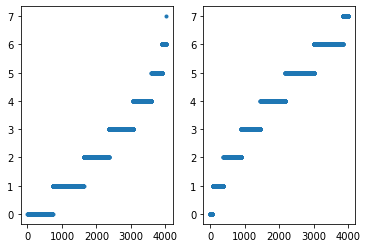

In [15]:
plt.subplot(1,2,1)
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.subplot(1,2,2)
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')

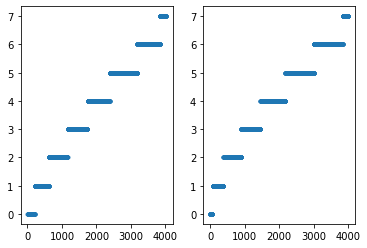

In [17]:
plt.subplot(1,2,1)
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.subplot(1,2,2)
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')

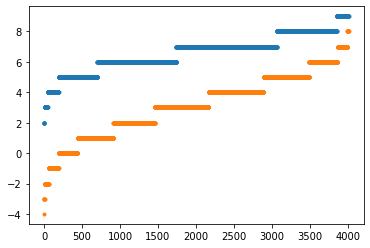

In [12]:

plt.plot(sorted(np.floor(np.divide(r_ej_list,0.1))), '.')
plt.plot(sorted(np.floor(np.divide(h_ej_list,0.1))), '.')